In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd
import datetime as dt
import numpy as np

class SNFile(object):
    ''' For reading in a raw mesonet data file after 2000 and correctly 
    parse the date and time into a datetime object in the same array (in UTC) 
    which replaces the original columns 1-2
    '''
    def __init__(self, filename):
        self.year = int(filename[-19:-15])
        self.month = int(filename[-15:-13])
        self.day = int(filename[-13:-11])
        self.datetime = dt.datetime(self.year,self.month,self.day)
        self.filename = filename

    def parse(self, time):
        # Converting from Julian Day with CST to standard datetime and UTC
        # check if we have gone past 00Z, in which we would need to add a day to the datetime object
        if time == '000000.0':
            self.datetime += dt.timedelta(days=1)
        hour,minute,second,msec = int(time[0:2]),int(time[2:4]),int(time[4:6]),int(time[-1])
        return self.datetime + dt.timedelta(hours=hour,minutes=minute,seconds=second,microseconds=msec*100000)
        
    def read(self):
        sn = pd.read_csv(self.filename, names=['time','T','RH','P','windsp','winddir'],
                         dtype={'time':np.str},header=1,parse_dates=[0],date_parser=self.parse)
        return sn

In [4]:
snfile = SNFile('../../../data/0106A_20151123_213427.txt')

In [5]:
filename   = '/Users/severe/Research/data/0106A_20151123_213427.txt'
starttime  = dt.datetime(2015,11,26,12,0,0,0)
endtime    = starttime + dt.timedelta(hours=24)

In [6]:
data = snfile.read()
met = data.set_index('time')


In [11]:
def dewpoint(T,RH):
    num = np.log(RH/100) + (17.625*T)/(243.04+T)
    denom = 17.625 - np.log(RH/100) - (17.625*T)/(243.04+T)
    return 243.04*num/denom

In [17]:
def plot():
    fig = plt.figure(1,figsize=[10,15])
    ax1 = fig.add_subplot(411)
    dates = mpl.dates.date2num(met[starttime:endtime].index)
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%HZ'))
    ln1 = ax1.plot(dates[::3000], 
                   met['windsp'][starttime:endtime][::3000], 
                   label='Wind Speed')
    plt.ylabel('Wind Speed (m/s)', multialignment='center')

    plt.setp(ax1.get_xticklabels(), visible=True)
    ax7 = ax1.twinx()
    ln3 = ax7.plot(dates[::3000], 
                   met['winddir'][starttime:endtime][::3000], 
                   '.k', linewidth=0.5, label='Wind Direction')
    plt.ylabel('Wind\nDirection\n(degrees)', multialignment='center')
    plt.ylim(0,360)
    lns = ln1+ln3
    labs = [l.get_label() for l in lns]
    ax7.legend(lns, labs, prop={'size':8})

    ax2 = fig.add_subplot(412, sharex=ax1)
    ln4 = ax2.plot(dates[::3000], 
             met['T'][starttime:endtime][::3000],
             'r',label='Temperature')
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.ylabel('Temperature\n(C)', multialignment='center')

#    ax8 = ax2.twinx()
    ln5 = ax2.plot(dates[::3000],
                  dewpoint(met['T'][starttime:endtime][::3000],met['RH'][starttime:endtime][::3000]),
                  'g',label='Dewpoint')
    lns = ln4+ln5
    labs = [l.get_label() for l in lns]
    plt.legend(lns,labs,prop={'size':8})
    
    ax3 = fig.add_subplot(413, sharex=ax1)
    ax3.plot(dates[::3000],
        met['RH'][starttime:endtime][::3000],'g',
        label='Relative Humidity')
    plt.setp(ax3.get_xticklabels(),visible=True)
    plt.ylabel('Relative Humidity\n(%)',multialignment='center')
    plt.legend(prop={'size':8})


    ax4 = fig.add_subplot(414, sharex=ax1)
    ax4.plot(dates[::3000], 
             met['P'][starttime:endtime][::3000],'k', 
             label='Station Pressure')
    plt.setp(ax4.get_xticklabels(), visible=True)
    plt.ylabel('Station\nPressure\n(mb)', multialignment='center')
    plt.legend(prop={'size':8})
#    plt.savefig('test.png',dpi=200)

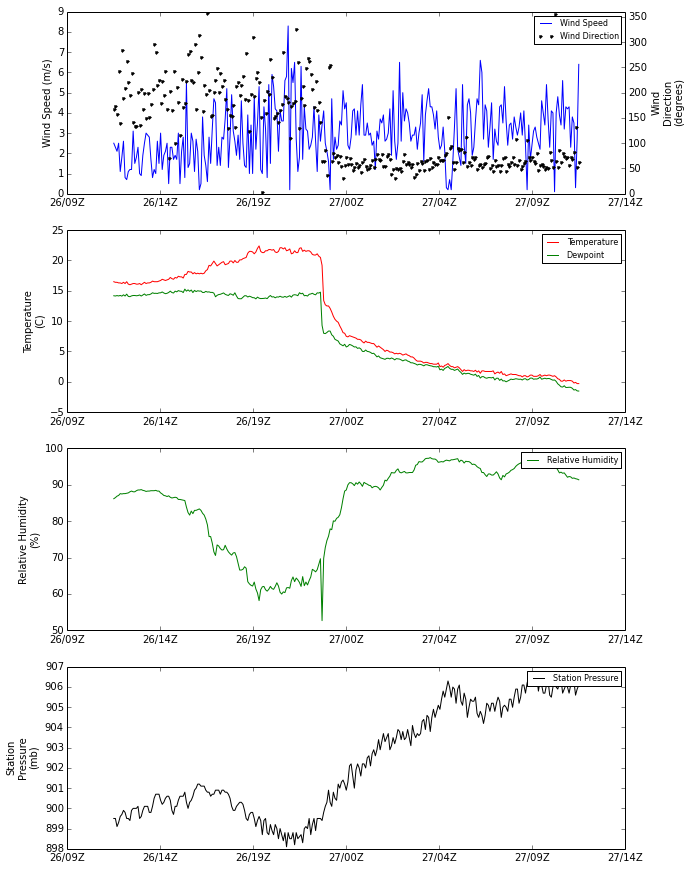

In [18]:
plot()
